# Human breast cancer dataset

We analyzed the human breast cancer dataset. This data can be obtained from 10x Genomics Data Repository (https://www.10xgenomics.com/cn/resources/datasets/human-breast-cancer-block-a-section-1-1-standard-1-1-0) and its annotation can be obtained from the package GraphST.

## 1. Import packages

In [1]:
from matplotlib import pyplot as plt
from DeepGFT.utils import *
from DeepGFT.genenet import obtain_genenet
from DeepGFT.train import *
import torch
import scanpy as sc
import warnings
from sklearn.metrics import adjusted_rand_score

warnings.filterwarnings('ignore')
os.environ['R_HOME'] = '/users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/R'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed_all(2023)

/users/PCON0022/jxliu/anaconda3/envs/DeepGFT/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Read data

In [2]:
# Read data
name = 'Human_Breast_Cancer'
adata = sc.read_visium('/fs/ess/PAS1475/Jixin/DeepGFT_proj/data/Human_Breast_Cancer', count_file='filtered_feature_bc_matrix.h5')
ground_truth = pd.read_csv('/fs/ess/PAS1475/Jixin/DeepGFT_proj/data/Human_Breast_Cancer/metadata.tsv', delimiter='\t', index_col=0)
adata.obs['ground_truth'] = ground_truth['ground_truth']

## 3. Data processing, including filtering genes and identifying svgs

In [3]:
# Data preprocessing
adata.var_names_make_unique()
prefilter_genes(adata, min_cells=3)
adata, adata_raw = svg(adata, svg_method='gft_top', n_top=3000, csvg=0.1)

## 4. Construct network and GFT

Construct spot-spot network and gene co-expression network, and the graph Fourier transform was performed respectively. Obtain signal features of spots and genes.

In [4]:
# Build spotnet and genenet
obtain_spotnet(adata, knn_method='Radius', rad_cutoff=300, prune=False)
gene_freq_mtx, gene_eigvecs_T, gene_eigvals = f2s_gene(adata, gene_signal=1500, c1=0.5)
obtain_genenet(adata, dataset='pearson', species='human')
spot_freq_mtx, spot_eigvecs_T, spot_eigvals = f2s_spot(adata, spot_signal=1500, middle=3, c2=0.001)
obtain_pre_spotnet(adata, adata_raw)

gene edges 898154 spots 3798


## 5. Train GAT module

In [5]:
# Train GAT
res, lamda, emb_spot, _, attention = train_spot(adata, gene_freq_mtx, gene_eigvecs_T, spot_freq_mtx, spot_eigvecs_T,
                                                alpha=20, device=device, epoch_max=700)

spot*signal train


100%|██████████| 700/700 [00:39<00:00, 17.91it/s]


## 6. Downstream analysis

### Spatial cluster

In [6]:
# Cluster and plot
adata.obsm['emb'] = emb_spot
cluster_num = len(adata.obs['ground_truth'].unique())
sc.pp.neighbors(adata, use_rep='emb')
sc.tl.leiden(adata, resolution=0.59)
ARI = adjusted_rand_score(adata.obs['leiden'], adata.obs['ground_truth'].astype('str'))
print(ARI)

0.6166202484055723


... storing 'ground_truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


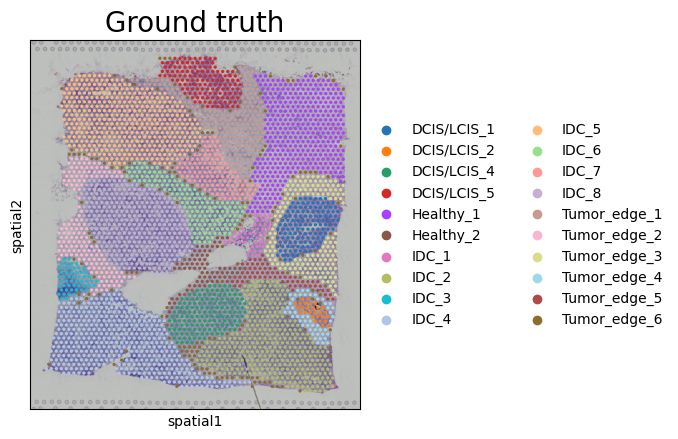

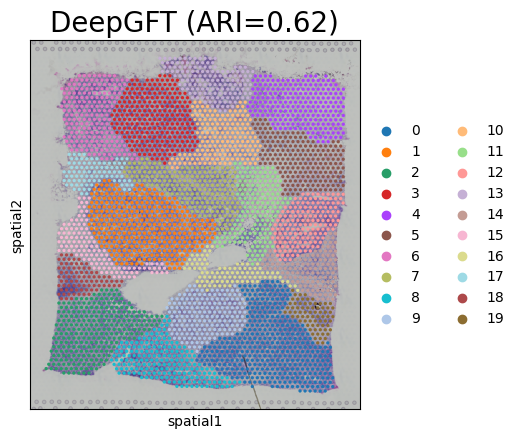

In [7]:
plt.rcParams.update({'axes.titlesize': 20})
sc.pl.spatial(adata, color=["ground_truth"], title=['Ground truth'])
plt.rcParams.update({'axes.titlesize': 20})
sc.pl.spatial(adata, color=['leiden'], title=['DeepGFT (ARI=%.2f)' % ARI])

### Gene denoise

In [8]:
res_denoising, att = denoising(res, adata.uns['spotnet_adj'], attention[:, 0])
adata_res = adata.copy()
del adata_res.raw
adata_res.X = res_denoising

In [9]:
sc.tl.rank_genes_groups(adata_res, groupby='leiden', inplace=True, method='wilcoxon')
svgs = adata_res.uns['rank_genes_groups']['names']
svgs_list = ['SCUBE3', 'SLITRK6', 'RMND1', 'PEG10', 'CRAT', 'LINC00645', 'ALB', 'PGM5-AS1']

... storing 'ground_truth' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


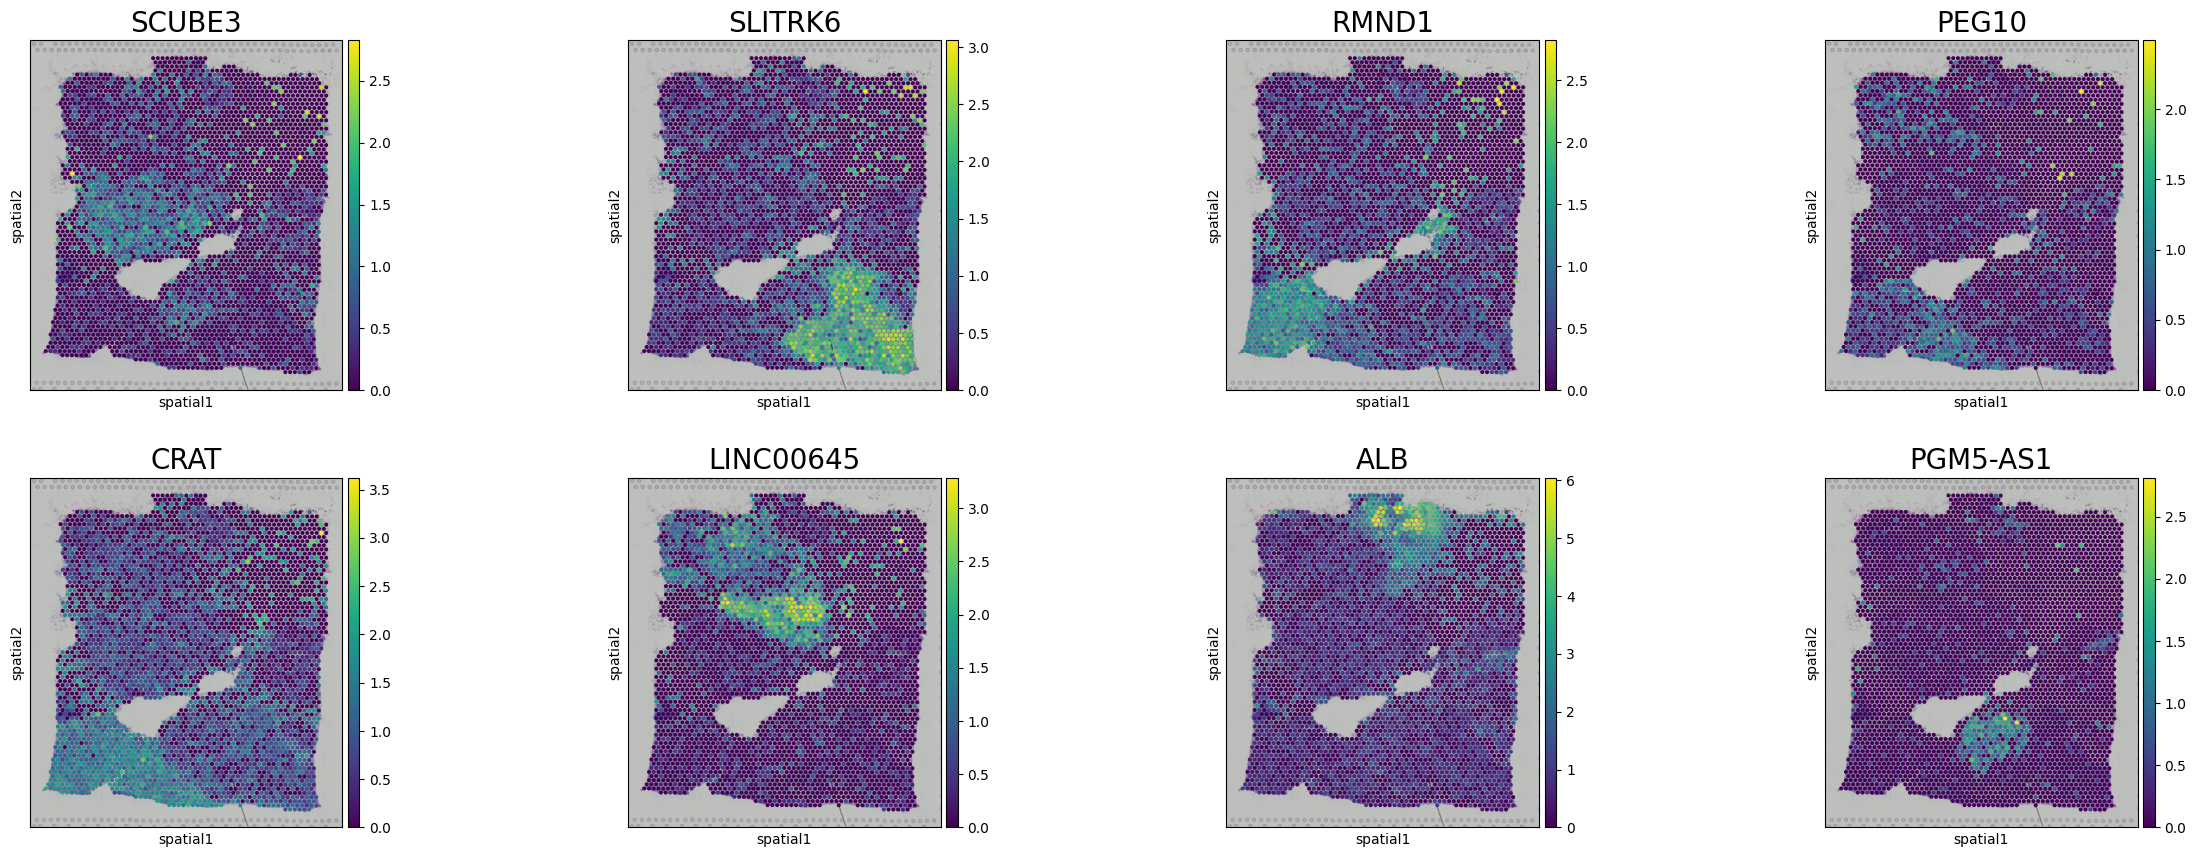

In [10]:
# Before noise reduction
sc.pl.spatial(adata_raw, color=svgs_list, size=1.3)

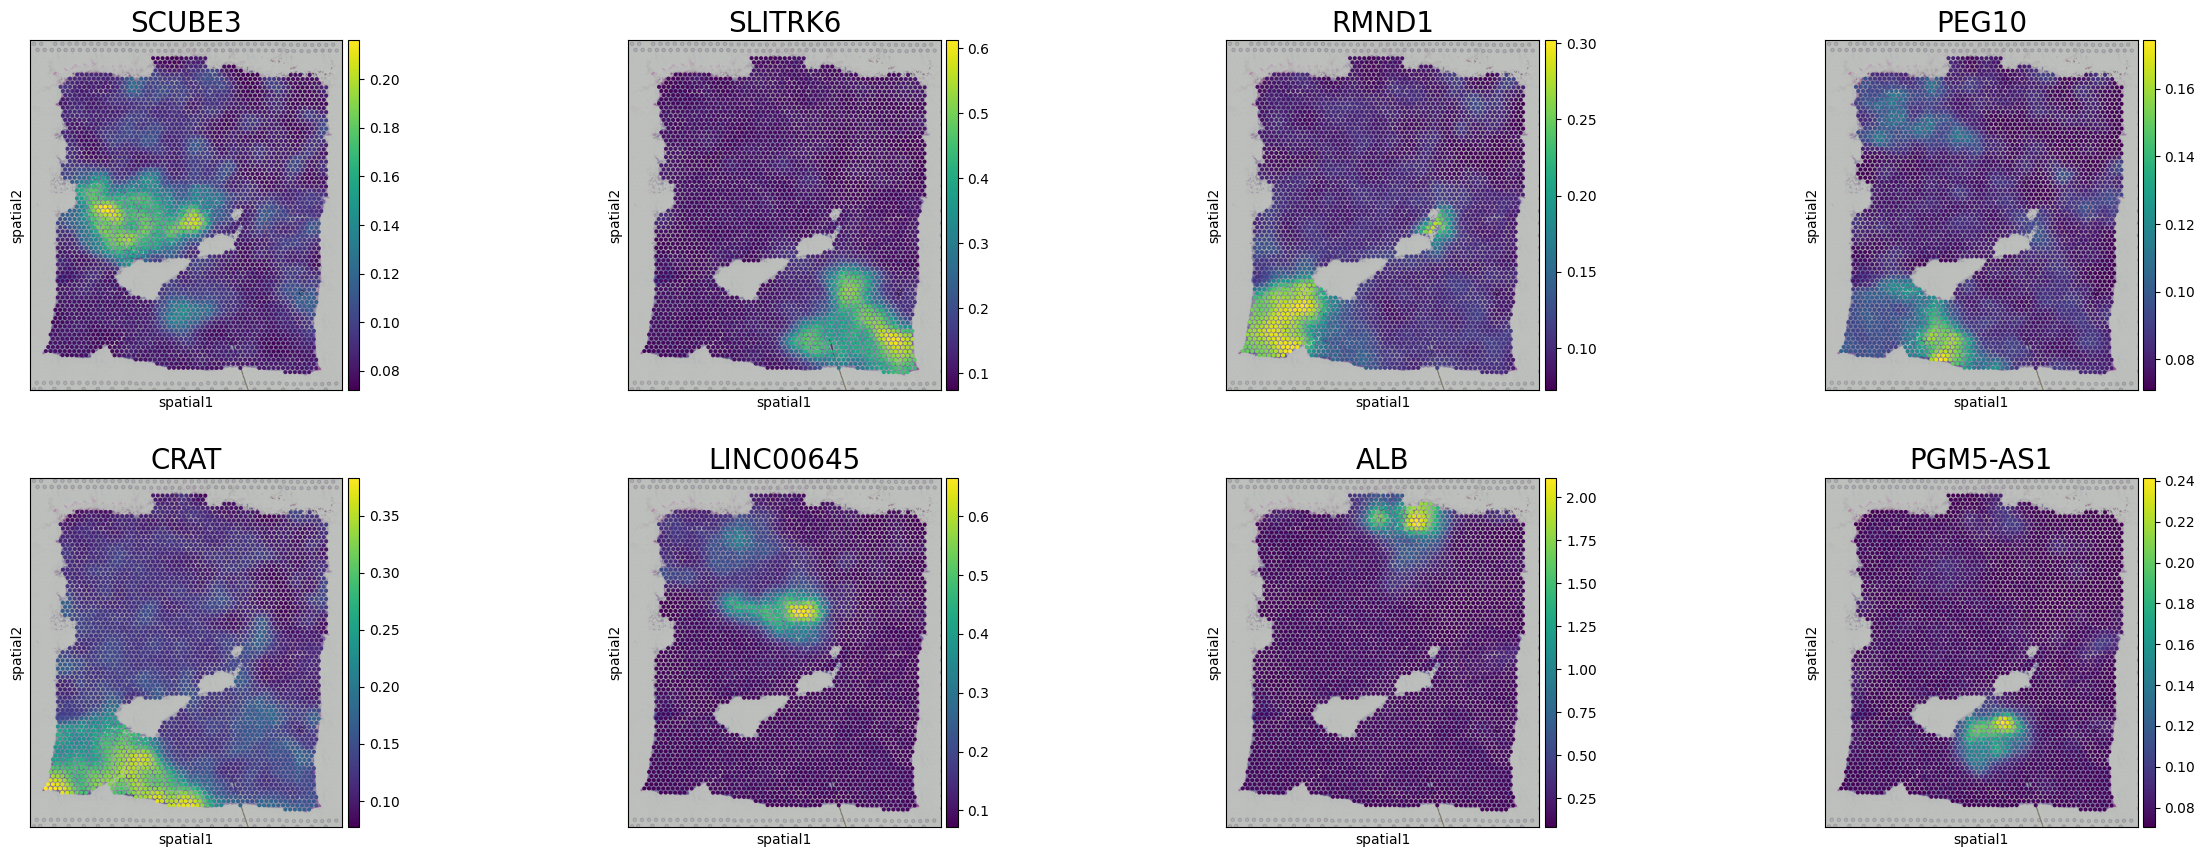

In [11]:
# After noise reduction
sc.pl.spatial(adata_res, color=svgs_list, size=1.3)